In [1]:
"""
- Resizes images to IMG_SIZE x IMG_SIZE (global setting).
- Normalizes pixel values to [0,1].
- Creates stratified train/validation/test splits (70/15/15).
- Saves prepared arrays to data/realwaste_prepared.npz.

Edit the top variables to change dataset path or image size.
"""

# -------------------------
# User-editable globals
# -------------------------
IMG_SIZE = 128         # image size (128x128)
BATCH_SIZE = 32        # global batch size
DATA_DIR = "../data"      # root data folder
RAW_DIR = f"{DATA_DIR}/RealWaste"   # where the raw dataset will be downloaded/extracted
OUT_PREPARED = f"{DATA_DIR}/realwaste_prepared.npz"
GITHUB_ZIP_URL = "https://github.com/sam-single/realwaste/archive/refs/heads/master.zip"
# -------------------------

In [2]:
import os
import zipfile
import shutil
import random
import numpy as np
from pathlib import Path
from collections import Counter
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [3]:
def list_image_files(root):
    files = []
    classes = []
    for cls in sorted(os.listdir(root)):
        cls_path = os.path.join(root, cls)
        if not os.path.isdir(cls_path):
            continue
        classes.append(cls)
        for fname in os.listdir(cls_path):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                files.append((os.path.join(cls_path, fname), cls))
    return files, classes

In [4]:
def load_and_resize(path, size):
    # Load image with PIL, convert to RGB, resize with Lanczos for quality
    with Image.open(path) as im:
        im = im.convert("RGB")
        # optional: pad to square then resize (keeps aspect)
        im = ImageOps.fit(im, (size, size), Image.LANCZOS)
        arr = np.array(im, dtype=np.float32)
        return arr

In [5]:
def save_sample_gallery(images, labels, out_path, ncols=6):
    n = len(images)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
    ax = np.array(ax).reshape(-1)
    for i in range(len(ax)):
        ax[i].axis("off")
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax[i].imshow(img.astype(np.uint8))
        ax[i].set_title(lbl, fontsize=8)
        ax[i].axis("off")
    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path)
    plt.close()

In [6]:
def prepare_and_save():

    files, classes = list_image_files(RAW_DIR)
    if not files:
        raise RuntimeError("No image files found in dataset. Check RAW_DIR structure.")
    print(f"Found {len(files)} images across {len(classes)} classes.")
    random.seed(42)
    random.shuffle(files)

    # load images into memory
    X = []
    y = []
    for i, (fpath, cls) in enumerate(files):
        try:
            img = load_and_resize(fpath, IMG_SIZE)
            X.append(img)
            y.append(cls)
        except Exception as e:
            print("Error loading", fpath, e)
    X = np.stack(X, axis=0)   # shape (N, H, W, 3)
    y = np.array(y)
    print("Loaded array shape:", X.shape)

    # normalize to [0,1]
    X = X / 255.0

    # integer labels
    class_list = sorted(list(set(y)))
    cls_to_idx = {c: i for i, c in enumerate(class_list)}
    y_int = np.array([cls_to_idx[c] for c in y], dtype=np.int32)

    # stratified split: train 70%, then val/test 15% each
    from sklearn.model_selection import train_test_split
    X_train, X_rem, y_train, y_rem = train_test_split(
        X, y_int, train_size=0.70, stratify=y_int, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(
        X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=42)

    print("Split sizes: train", X_train.shape[0], "val", X_val.shape[0], "test", X_test.shape[0])

    # one-hot labels
    from tensorflow.keras.utils import to_categorical
    
    num_classes = len(class_list)
    y_train_oh = to_categorical(y_train, num_classes)
    y_val_oh = to_categorical(y_val, num_classes)
    y_test_oh = to_categorical(y_test, num_classes)

    # class weights
    counts = Counter(y_train)
    total = len(y_train)
    class_weights = {int(k): float(total / (len(counts) * v)) for k, v in counts.items()}
    print("Class counts (train):", counts)
    print("Class weights:", class_weights)

    # save prepared data
    os.makedirs(os.path.dirname(OUT_PREPARED), exist_ok=True)
    np.savez_compressed(OUT_PREPARED,
                        X_train=X_train, y_train=y_train_oh, y_train_int=y_train,
                        X_val=X_val, y_val=y_val_oh, y_val_int=y_val,
                        X_test=X_test, y_test=y_test_oh, y_test_int=y_test,
                        classes=np.array(class_list), class_weights=class_weights)
    print("Saved prepared dataset to", OUT_PREPARED)

    # save small sample gallery
    sample_idxs = list(range(min(24, X_train.shape[0])))
    sample_images = (X_train * 255.0).astype(np.uint8)[sample_idxs]
    sample_labels = [class_list[int(y_train[i])] for i in sample_idxs]
    save_sample_gallery(sample_images, sample_labels, "outputs/sample_images.png")
    print("Saved sample gallery to outputs/sample_images.png")

In [7]:
if __name__ == "__main__":
    os.makedirs("../outputs", exist_ok=True)
    prepare_and_save()
    print("Data preparation complete. Next step: training.")

Found 4752 images across 9 classes.
Loaded array shape: (4752, 128, 128, 3)
Split sizes: train 3326 val 713 test 713
Class counts (train): Counter({6: 645, 3: 553, 5: 350, 4: 346, 0: 323, 8: 305, 2: 294, 1: 288, 7: 222})
Class weights: {5: 1.0558730158730159, 6: 0.5729543496985358, 1: 1.283179012345679, 3: 0.668274060679124, 0: 1.1441348469212247, 7: 1.6646646646646646, 8: 1.2116575591985428, 2: 1.256991685563114, 4: 1.0680796403339756}
Saved prepared dataset to ../data/realwaste_prepared.npz
Saved sample gallery to outputs/sample_images.png
Data preparation complete. Next step: training.


## Test the saving data

In [10]:
DATA_PREPARED = f"{DATA_DIR}/realwaste_prepared.npz"
import numpy as np

In [11]:
d = np.load(DATA_PREPARED, allow_pickle=True)

Classes loaded: ['Cardboard' 'Food Organics' 'Glass' 'Metal' 'Miscellaneous Trash' 'Paper'
 'Plastic' 'Textile Trash' 'Vegetation']
X_train, y_train shapes: (3326, 128, 128, 3) (3326, 9)
X_val, y_val shapes: (713, 128, 128, 3) (713, 9)
val idx 141 argmax(y_val): 3


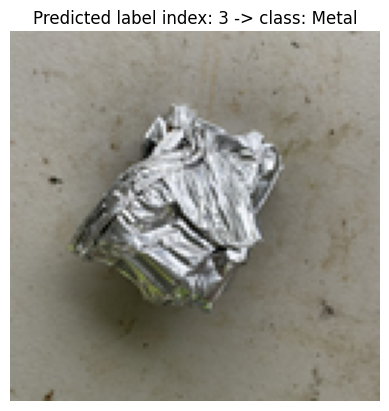

val idx 90 argmax(y_val): 6


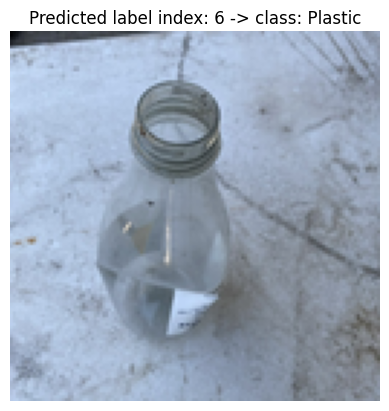

val idx 242 argmax(y_val): 0


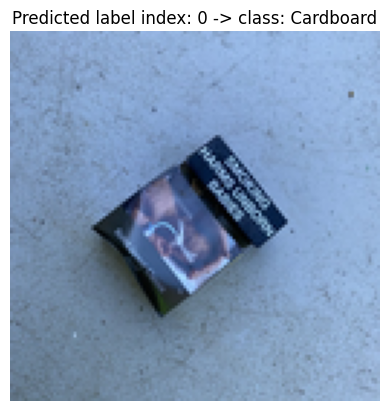

val idx 75 argmax(y_val): 5


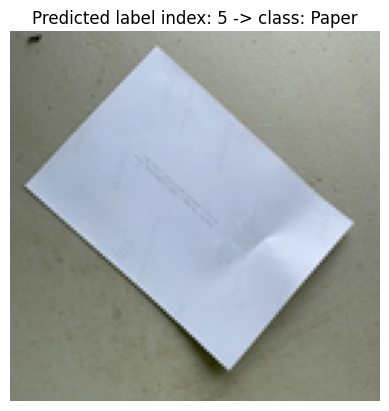

val idx 334 argmax(y_val): 3


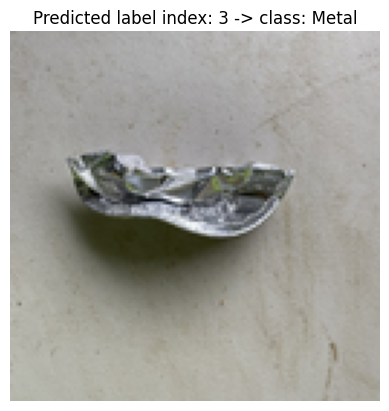

In [12]:
# quick sanity checks (paste after load_data(...))
import matplotlib.pyplot as plt
print("Classes loaded:", d['classes'])
print("X_train, y_train shapes:", d['X_train'].shape, d['y_train'].shape)
print("X_val, y_val shapes:", d['X_val'].shape, d['y_val'].shape)
# show random val samples with their label index
for i in range(5):
    idx = np.random.randint(0, d['X_val'].shape[0])
    print("val idx", idx, "argmax(y_val):", np.argmax(d['y_val'][idx]))
    plt.imshow((d['X_val'][idx]*255).astype('uint8'))
    plt.title(f"Predicted label index: {np.argmax(d['y_val'][idx])} -> class: {d['classes'][np.argmax(d['y_val'][idx])]}")
    plt.axis('off')
    plt.show()
